# Wikipedia Title Clustering with DBSCAN and K-Means

This notebook performs comprehensive clustering analysis on Wikipedia article titles using both DBSCAN and K-Means algorithms. We'll generate embeddings for titles, apply dimensionality reduction, tune hyperparameters, evaluate cluster quality, provide human-readable cluster labels, and export all results.

## Approach

1. Embed Wikipedia article titles using `sentence-transformers/all-MiniLM-L6-v2` (or TF-IDF if unavailable)
2. Apply dimensionality reduction (UMAP or PCA) to improve clustering efficiency
3. Tune and apply DBSCAN clustering with cosine distance
4. Tune and apply MiniBatchKMeans for scalability
5. Compare clustering approaches and generate meaningful cluster labels
6. (Optional) Compare to existing Louvain community assignments
7. Visualize results and save all required outputs

## 1. Environment Setup

In [ ]:
import ast
import datetime
import json
import logging
import os
import re
import time
import warnings
from collections import Counter, defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from kneed import KneeLocator
from scipy import sparse
from sklearn.cluster import DBSCAN, MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.metrics import (adjusted_rand_score, calinski_harabasz_score,
                            davies_bouldin_score, normalized_mutual_info_score,
                            silhouette_samples, silhouette_score)
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize

# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s] %(message)s",
    handlers=[
        logging.FileHandler("../data/v0.0/log.txt"),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger("wiki_clustering")
logger.info("Starting Wikipedia title clustering")

# Set random seeds for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Ignore certain warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Define output paths
BASE_PATH = "../data/v0.0/ml_test"
MASTER_FILE = os.path.join(BASE_PATH, "wiki_clusters.parquet")
DBSCAN_SUMMARY_FILE = os.path.join(BASE_PATH, "wiki_dbscan_summary.csv")
KMEANS_SUMMARY_FILE = os.path.join(BASE_PATH, "wiki_kmeans_summary.csv")
EVAL_FILE = os.path.join(BASE_PATH, "cluster_eval.json")

# Create output directory if it doesn't exist
os.makedirs(BASE_PATH, exist_ok=True)

# Timer to track overall execution
start_time = time.time()

2025-09-02 20:36:26,723 [INFO] Starting Wikipedia title clustering


## 2. Data Loading and Preprocessing

In [2]:
# Load the Wikipedia dataset
logger.info("Loading dataset from CSV")
df = pd.read_csv(f"{BASE_PATH}df_nq_version0.csv")
logger.info(f"Loaded {len(df)} rows with columns: {', '.join(df.columns)}")

# Check for missing title values
missing_titles = df["d_properties_document_title"].isna().sum()
logger.info(f"Found {missing_titles} rows with missing titles")

if missing_titles > 0:
    # Use slug as fallback for missing titles
    df.loc[df["d_properties_document_title"].isna(), "d_properties_document_title"] = \
        df.loc[df["d_properties_document_title"].isna(), "d_properties_title_encode"].str.replace("_", " ")
    
    # Any remaining missing titles, just use the ID as string
    df.loc[df["d_properties_document_title"].isna(), "d_properties_document_title"] = \
        "Article " + df.loc[df["d_properties_document_title"].isna(), "id"].astype(str)

# Parse cites_ids safely
def parse_list(x):
    """Safely parse a string representation of a list into an actual list."""
    if isinstance(x, list):
        return x
    if pd.isna(x):
        return []
    try:
        result = ast.literal_eval(x)
        if isinstance(result, list):
            return result
        else:
            return []
    except (ValueError, SyntaxError):
        return []

df["cites_ids"] = df["cites_ids"].apply(parse_list)

# Basic statistics
logger.info(f"Number of unique articles: {df['id'].nunique()}")
logger.info(f"Number of unique titles: {df['d_properties_document_title'].nunique()}")

# Display sample data
df.head()

2025-09-02 20:36:26,733 [INFO] Loading dataset from CSV
2025-09-02 20:36:27,626 [INFO] Loaded 108071 rows with columns: id, d_properties_document_title, d_properties_title_encode, cites_ids
2025-09-02 20:36:27,626 [INFO] Loaded 108071 rows with columns: id, d_properties_document_title, d_properties_title_encode, cites_ids
2025-09-02 20:36:27,632 [INFO] Found 1 rows with missing titles
2025-09-02 20:36:27,632 [INFO] Found 1 rows with missing titles
2025-09-02 20:36:37,900 [INFO] Number of unique articles: 108071
2025-09-02 20:36:37,900 [INFO] Number of unique articles: 108071
2025-09-02 20:36:37,922 [INFO] Number of unique titles: 108071
2025-09-02 20:36:37,922 [INFO] Number of unique titles: 108071


,id,d_properties_document_title,d_properties_title_encode,cites_ids
0,0,Therefore sign,Therefore_sign,"[6352, 2622, 5393, 3079, 15650, 33906, 13375, ..."
1,1,Watchman (law enforcement),Watchman_(law_enforcement),"[4286, 4215, 2819, 864, 5115, 3220, 21000, 156..."
2,3,Super Bowl 50 halftime show,Super_Bowl_50_halftime_show,"[6341, 1832, 360, 1739, 4108, 138, 73, 1941, 1..."
3,5,A Whiter Shade of Pale,A_Whiter_Shade_of_Pale,"[547, 1646, 3958, 423, 9518, 8998, 9020, 8938,..."
4,6,Globe,Globe,"[258, 2819, 600, 1188, 1564, 15616, 21607, 123..."


## 3. Text Embedding

We'll try to use the more powerful `sentence-transformers` model first, but fall back to TF-IDF if that's not available.

In [3]:
# Try to import sentence-transformers
embedding_method = None
embedding_model_name = None
embeddings = None

try:
    from sentence_transformers import SentenceTransformer
    logger.info("Successfully imported sentence-transformers")
    
    # Define embedding function using sentence-transformers
    def embed_titles_transformer(titles, batch_size=1024):
        """Generate embeddings for titles using sentence-transformers."""
        model_name = "all-MiniLM-L6-v2"
        device = "cpu"  # force CPU; avoids the Pascal+CUDA12 issue
        
        logger.info(f"Loading sentence transformer model: {model_name}")
        model = SentenceTransformer(model_name, device=device)
        
        logger.info(f"Embedding {len(titles)} titles with batch size {batch_size}")
        embeddings = model.encode(
            titles,
            batch_size=batch_size,
            show_progress_bar=True,
            normalize_embeddings=True,  # L2 normalize for cosine similarity
            device=device
        )
        
        logger.info(f"Embeddings shape: {embeddings.shape}")
        return embeddings, model_name
    
    # Generate embeddings
    logger.info("Generating embeddings with sentence-transformers")
    embeddings, embedding_model_name = embed_titles_transformer(df["d_properties_document_title"].tolist())
    embedding_method = "transformer"
    
except ImportError:
    logger.warning("sentence-transformers not available, falling back to TF-IDF")
    
    # Define embedding function using TF-IDF
    def embed_titles_tfidf(titles):
        """Generate embeddings for titles using TF-IDF."""
        logger.info("Creating TF-IDF vectorizer")
        vectorizer = TfidfVectorizer(
            max_features=250000,
            min_df=3,
            ngram_range=(1, 2),  # Word n-grams
            analyzer='word',
            sublinear_tf=True,
        )
        
        char_vectorizer = TfidfVectorizer(
            max_features=100000,
            min_df=3,
            ngram_range=(3, 5),  # Character n-grams
            analyzer='char',
            sublinear_tf=True,
        )
        
        logger.info("Fitting and transforming with word TF-IDF")
        X_word = vectorizer.fit_transform(titles)
        
        logger.info("Fitting and transforming with character TF-IDF")
        X_char = char_vectorizer.fit_transform(titles)
        
        # Combine both feature sets
        X_combined = sparse.hstack([X_word, X_char])
        
        # L2 normalize
        logger.info("Normalizing combined TF-IDF features")
        X_normalized = normalize(X_combined, norm='l2')
        
        model_name = "TF-IDF (word n-grams=1-2, char n-grams=3-5)"
        logger.info(f"TF-IDF embedding shape: {X_normalized.shape}")
        return X_normalized, model_name
    
    # Generate embeddings
    logger.info("Generating embeddings with TF-IDF")
    embeddings, embedding_model_name = embed_titles_tfidf(df["d_properties_document_title"].tolist())
    embedding_method = "tfidf"

# Log embedding information
logger.info(f"Embedding method: {embedding_method}")
logger.info(f"Embedding model: {embedding_model_name}")
if isinstance(embeddings, np.ndarray):
    logger.info(f"Embedding shape: {embeddings.shape}")
else:
    logger.info(f"Embedding shape: {embeddings.shape}")
    logger.info(f"Embedding density: {embeddings.nnz / (embeddings.shape[0] * embeddings.shape[1]):.4f}")

/home/zeneto/projects/kg4ai/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-09-02 20:36:45,485 [INFO] Successfully imported sentence-transformers
2025-09-02 20:36:45,486 [INFO] Generating embeddings with sentence-transformers
2025-09-02 20:36:45,491 [INFO] Loading sentence transformer model: all-MiniLM-L6-v2
2025-09-02 20:36:45,493 [INFO] Load pretrained SentenceTransformer: all-MiniLM-L6-v2
2025-09-02 20:36:45,485 [INFO] Successfully imported sentence-transformers
2025-09-02 20:36:45,486 [INFO] Generating embeddings with sentence-transformers
2025-09-02 20:36:45,491 [INFO] Loading sentence transformer model: all-MiniLM-L6-v2
2025-09-02 20:36:45,493 [INFO] Load pretrained SentenceTransformer: all-MiniLM-L6-v2
2025-09-02 20:36:47,547 [INFO] Embedding 108071 titles with batch size 1024
2025-09-0

## 4. Dimensionality Reduction

We'll try UMAP for dimensionality reduction, but fall back to PCA if UMAP is not available.

In [4]:
# Try to perform dimensionality reduction with UMAP, falling back to PCA
projection_method = None
projection_name = None
reduced_embeddings = None

try:
    import umap
    logger.info("Successfully imported UMAP")
    
    # Define UMAP reduction function
    def reduce_with_umap(embeddings, n_components=15, random_state=RANDOM_STATE):
        """Reduce dimensionality using UMAP."""
        logger.info(f"Reducing dimensions with UMAP to {n_components} components")
        
        # Handle sparse matrices
        if sparse.issparse(embeddings):
            logger.info("Converting sparse matrix to dense for UMAP")
            # For large datasets, consider using sparse UMAP or sampling
            if embeddings.shape[0] > 50000:
                logger.info("Large dataset detected, sampling 50000 points for UMAP fitting")
                idx = np.random.choice(embeddings.shape[0], 50000, replace=False)
                reducer = umap.UMAP(
                    n_components=n_components,
                    n_neighbors=50,
                    min_dist=0.0,
                    metric='cosine',
                    random_state=random_state
                )
                reducer.fit(embeddings[idx].toarray())
                reduced = reducer.transform(embeddings.toarray())
            else:
                reducer = umap.UMAP(
                    n_components=n_components,
                    n_neighbors=50,
                    min_dist=0.0,
                    metric='cosine',
                    random_state=random_state
                )
                reduced = reducer.fit_transform(embeddings.toarray())
        else:
            if embeddings.shape[0] > 50000:
                logger.info("Large dataset detected, sampling 50000 points for UMAP fitting")
                idx = np.random.choice(embeddings.shape[0], 50000, replace=False)
                reducer = umap.UMAP(
                    n_components=n_components,
                    n_neighbors=50,
                    min_dist=0.0,
                    metric='cosine',
                    random_state=random_state
                )
                reducer.fit(embeddings[idx])
                reduced = reducer.transform(embeddings)
            else:
                reducer = umap.UMAP(
                    n_components=n_components,
                    n_neighbors=50,
                    min_dist=0.0,
                    metric='cosine',
                    random_state=random_state
                )
                reduced = reducer.fit_transform(embeddings)
        
        logger.info(f"Reduced embedding shape: {reduced.shape}")
        return reduced, f"UMAP-{n_components}"
    
    # Reduce embeddings with UMAP
    reduced_embeddings, projection_name = reduce_with_umap(embeddings)
    projection_method = "umap"
    
except ImportError:
    logger.warning("UMAP not available, falling back to PCA")
    
    # Define PCA reduction function
    def reduce_with_pca(embeddings, n_components=50, random_state=RANDOM_STATE):
        """Reduce dimensionality using PCA."""
        logger.info(f"Reducing dimensions with PCA to {n_components} components")
        
        # Handle sparse matrices
        if sparse.issparse(embeddings):
            logger.info("Converting sparse matrix to dense for PCA")
            # For large datasets, consider using randomized PCA
            if embeddings.shape[0] > 50000:
                logger.info("Large dataset detected, using randomized PCA")
                pca = PCA(
                    n_components=n_components,
                    whiten=True,
                    random_state=random_state,
                    svd_solver='randomized'
                )
            else:
                pca = PCA(n_components=n_components, whiten=True, random_state=random_state)
                
            reduced = pca.fit_transform(embeddings.toarray())
        else:
            if embeddings.shape[0] > 50000:
                logger.info("Large dataset detected, using randomized PCA")
                pca = PCA(
                    n_components=n_components,
                    whiten=True,
                    random_state=random_state,
                    svd_solver='randomized'
                )
            else:
                pca = PCA(n_components=n_components, whiten=True, random_state=random_state)
                
            reduced = pca.fit_transform(embeddings)
        
        logger.info(f"Reduced embedding shape: {reduced.shape}")
        logger.info(f"Explained variance ratio sum: {pca.explained_variance_ratio_.sum():.4f}")
        return reduced, f"PCA-{n_components}"
    
    # Reduce embeddings with PCA
    reduced_embeddings, projection_name = reduce_with_pca(embeddings)
    projection_method = "pca"

# Log projection information
logger.info(f"Projection method: {projection_method}")
logger.info(f"Projection name: {projection_name}")
logger.info(f"Reduced embeddings shape: {reduced_embeddings.shape}")

2025-09-02 20:40:29,137 [INFO] Successfully imported UMAP
2025-09-02 20:40:29,138 [INFO] Reducing dimensions with UMAP to 15 components
2025-09-02 20:40:29,139 [INFO] Large dataset detected, sampling 50000 points for UMAP fitting
2025-09-02 20:40:29,138 [INFO] Reducing dimensions with UMAP to 15 components
2025-09-02 20:40:29,139 [INFO] Large dataset detected, sampling 50000 points for UMAP fitting
2025-09-02 20:44:24,263 [INFO] Reduced embedding shape: (108071, 15)
2025-09-02 20:44:24,268 [INFO] Projection method: umap
2025-09-02 20:44:24,269 [INFO] Projection name: UMAP-15
2025-09-02 20:44:24,270 [INFO] Reduced embeddings shape: (108071, 15)
2025-09-02 20:44:24,263 [INFO] Reduced embedding shape: (108071, 15)
2025-09-02 20:44:24,268 [INFO] Projection method: umap
2025-09-02 20:44:24,269 [INFO] Projection name: UMAP-15
2025-09-02 20:44:24,270 [INFO] Reduced embeddings shape: (108071, 15)


## 5. DBSCAN Clustering

We'll tune DBSCAN parameters using k-distance plots to find the optimal epsilon and sweep over `min_samples` values.

In [5]:
# Compute k-distance for different min_samples values
dbscan_results = []
min_samples_values = [5, 10, 15]

# Helper function to find elbow in k-distance curve
def find_elbow(distances):
    """Find the elbow point in a k-distance curve."""
    sorted_dists = np.sort(distances)
    points = np.arange(len(sorted_dists))
    
    try:
        kneedle = KneeLocator(
            points, sorted_dists, 
            curve='convex', direction='increasing',
            S=1.0
        )
        if kneedle.elbow is not None:
            elbow_idx = kneedle.elbow
            return sorted_dists[elbow_idx]
        else:
            # Fallback if no elbow detected
            return np.percentile(sorted_dists, 95)
    except Exception as e:
        logger.warning(f"Error finding elbow: {str(e)}")
        return np.percentile(sorted_dists, 95)

# Find eps values for each min_samples
logger.info("Computing k-distance plots for DBSCAN parameter tuning")
k_dist_plots = {}

for min_samples in min_samples_values:
    logger.info(f"Computing distances for min_samples={min_samples}")
    
    # Use NearestNeighbors to compute distances
    if projection_method == "umap" or projection_method == "pca":
        # Use euclidean distance for reduced embeddings
        nn = NearestNeighbors(
            n_neighbors=min_samples + 1,  # +1 because the point itself is included
            algorithm="auto",
            metric="euclidean"
        )
        nn.fit(reduced_embeddings)
        distances, _ = nn.kneighbors(reduced_embeddings)
        # Get the distance to the min_samples-th neighbor
        k_distances = distances[:, -1]
    else:
        # Use cosine distance for raw embeddings
        nn = NearestNeighbors(
            n_neighbors=min_samples + 1,
            algorithm="brute",
            metric="cosine"
        )
        if sparse.issparse(embeddings):
            nn.fit(embeddings)
            distances, _ = nn.kneighbors(embeddings)
        else:
            nn.fit(embeddings)
            distances, _ = nn.kneighbors(embeddings)
        # Get the distance to the min_samples-th neighbor
        k_distances = distances[:, -1]
    
    k_dist_plots[min_samples] = k_distances
    
    # Find the elbow point
    elbow_eps = find_elbow(k_distances)
    logger.info(f"Elbow point for min_samples={min_samples}: eps={elbow_eps:.4f}")
    
    # Test eps values around the elbow
    eps_values = [
        elbow_eps * 0.8,  # 20% below
        elbow_eps * 0.9,  # 10% below
        elbow_eps,        # At elbow
        elbow_eps * 1.1,  # 10% above
        elbow_eps * 1.2   # 20% above
    ]
    
    for eps in eps_values:
        logger.info(f"Running DBSCAN with min_samples={min_samples}, eps={eps:.4f}")
        
        # Run DBSCAN
        if projection_method == "umap" or projection_method == "pca":
            # Use euclidean distance for reduced embeddings
            dbscan = DBSCAN(
                eps=eps,
                min_samples=min_samples,
                metric="euclidean",
                n_jobs=-1
            )
            labels = dbscan.fit_predict(reduced_embeddings)
        else:
            # Use cosine distance for raw embeddings
            dbscan = DBSCAN(
                eps=eps,
                min_samples=min_samples,
                metric="cosine",
                n_jobs=-1
            )
            if sparse.issparse(embeddings):
                labels = dbscan.fit_predict(embeddings)
            else:
                labels = dbscan.fit_predict(embeddings)
        
        # Analyze results
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)
        
        # Compute silhouette score on a sample if dataset is large
        if len(df) > 10000:
            # Sample points for silhouette calculation
            idx = np.random.choice(len(df), 10000, replace=False)
            sample_labels = labels[idx]
            
            # Filter out noise points
            non_noise_idx = idx[sample_labels != -1]
            if len(non_noise_idx) > 0 and len(set(labels[non_noise_idx])) > 1:
                if projection_method == "umap" or projection_method == "pca":
                    sil = silhouette_score(
                        reduced_embeddings[non_noise_idx],
                        labels[non_noise_idx],
                        metric="euclidean",
                        sample_size=5000
                    )
                else:
                    if sparse.issparse(embeddings):
                        sil = silhouette_score(
                            embeddings[non_noise_idx].toarray(),
                            labels[non_noise_idx],
                            metric="cosine",
                            sample_size=5000
                        )
                    else:
                        sil = silhouette_score(
                            embeddings[non_noise_idx],
                            labels[non_noise_idx],
                            metric="cosine",
                            sample_size=5000
                        )
            else:
                sil = -1.0  # Default for insufficient clusters or all noise
        else:
            # For smaller datasets, use all non-noise points
            non_noise_idx = labels != -1
            if np.sum(non_noise_idx) > 0 and len(set(labels[non_noise_idx])) > 1:
                if projection_method == "umap" or projection_method == "pca":
                    sil = silhouette_score(
                        reduced_embeddings[non_noise_idx],
                        labels[non_noise_idx],
                        metric="euclidean"
                    )
                else:
                    if sparse.issparse(embeddings):
                        sil = silhouette_score(
                            embeddings[non_noise_idx].toarray(),
                            labels[non_noise_idx],
                            metric="cosine"
                        )
                    else:
                        sil = silhouette_score(
                            embeddings[non_noise_idx],
                            labels[non_noise_idx],
                            metric="cosine"
                        )
            else:
                sil = -1.0
        
        # # Store results
        # result = {
        #     "min_samples": min_samples,
        #     "eps": eps,
        #     "n_clusters": n_clusters,
        #     "n_noise": n_noise,
        #     "noise_percent": n_noise / len(df) * 100,
        #     "silhouette": sil,
        #     "labels": labels,
        #     "core_samples_mask": np.zeros(len(labels), dtype=bool) if not hasattr(dbscan, 'core_sample_indices_') 
        #                         else np.zeros(len(labels), dtype=bool).scatter(dbscan.core_sample_indices_, True)
        # }
        
        # dbscan_results.append(result)
        
        # logger.info(f"DBSCAN result: {n_clusters} clusters, {n_noise} noise points ({result['noise_percent']:.1f}%), silhouette={sil:.3f}")

        # Build core-sample mask correctly
        core_samples_mask = np.zeros(len(labels), dtype=bool)
        if hasattr(dbscan, "core_sample_indices_") and dbscan.core_sample_indices_ is not None:
            core_samples_mask[dbscan.core_sample_indices_] = True

        # Store results
        result = {
            "min_samples": min_samples,
            "eps": float(eps),
            "n_clusters": int(n_clusters),
            "n_noise": int(n_noise),
            "noise_percent": float(n_noise / len(df) * 100),
            "silhouette": float(sil),
            "labels": labels,                  # np.ndarray is fine; convert to list later if serializing to JSON
            "core_samples_mask": core_samples_mask
        }
        dbscan_results.append(result)

        logger.info(
            f"DBSCAN result: {n_clusters} clusters, {n_noise} noise points "
            f"({result['noise_percent']:.1f}%), silhouette={sil:.3f}"
        )

2025-09-02 20:44:24,319 [INFO] Computing k-distance plots for DBSCAN parameter tuning
2025-09-02 20:44:24,330 [INFO] Computing distances for min_samples=5
2025-09-02 20:44:24,330 [INFO] Computing distances for min_samples=5
2025-09-02 20:44:30,903 [INFO] Elbow point for min_samples=5: eps=0.5609
2025-09-02 20:44:30,904 [INFO] Running DBSCAN with min_samples=5, eps=0.4487
2025-09-02 20:44:30,903 [INFO] Elbow point for min_samples=5: eps=0.5609
2025-09-02 20:44:30,904 [INFO] Running DBSCAN with min_samples=5, eps=0.4487
2025-09-02 20:44:45,051 [INFO] DBSCAN result: 6 clusters, 595 noise points (0.6%), silhouette=-0.179
2025-09-02 20:44:45,053 [INFO] Running DBSCAN with min_samples=5, eps=0.5048
2025-09-02 20:44:45,051 [INFO] DBSCAN result: 6 clusters, 595 noise points (0.6%), silhouette=-0.179
2025-09-02 20:44:45,053 [INFO] Running DBSCAN with min_samples=5, eps=0.5048
2025-09-02 20:45:00,982 [INFO] DBSCAN result: 6 clusters, 297 noise points (0.3%), silhouette=-0.133
2025-09-02 20:45:00

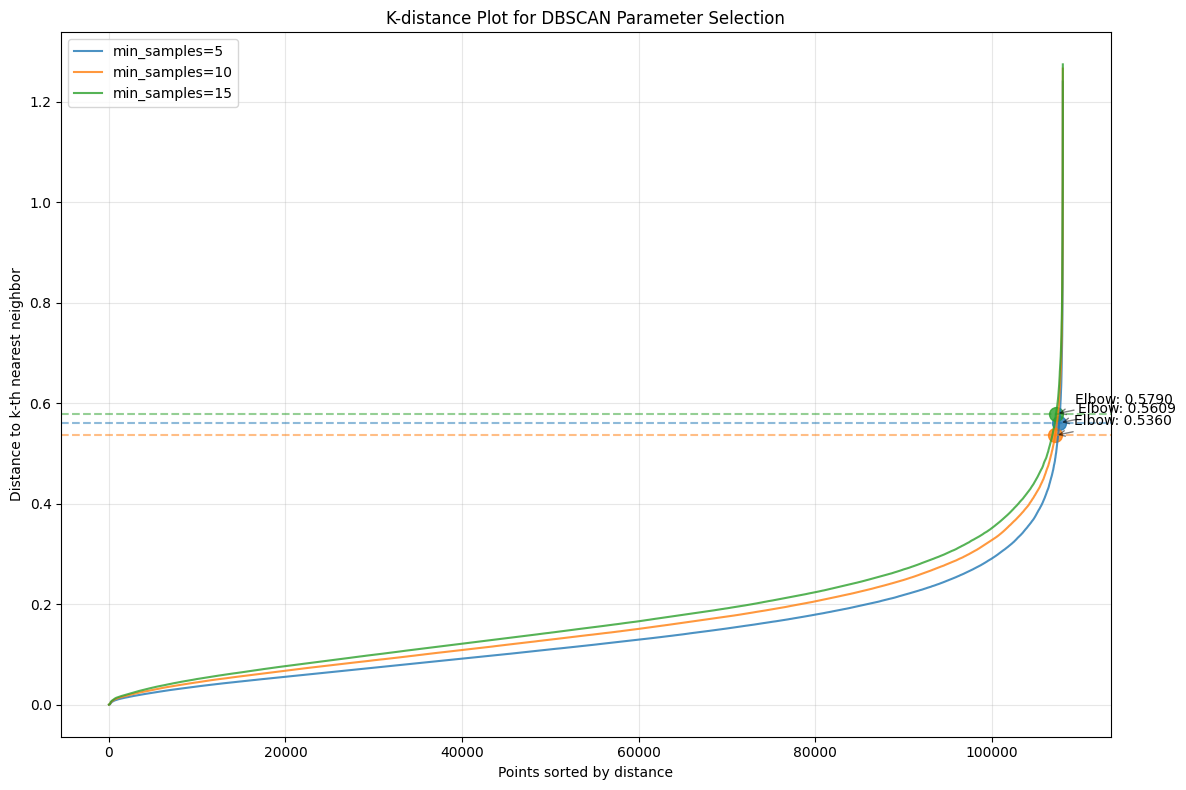

In [6]:
# Plot the k-distance curves
plt.figure(figsize=(12, 8))

for min_samples, distances in k_dist_plots.items():
    # Sort distances for clearer visualization
    sorted_dists = np.sort(distances)
    
    # Plot k-distance curve
    plt.plot(
        sorted_dists,
        label=f'min_samples={min_samples}',
        alpha=0.8
    )
    
    # Find and mark the elbow point
    elbow_eps = find_elbow(distances)
    elbow_idx = np.where(sorted_dists >= elbow_eps)[0][0]
    
    plt.axhline(
        y=elbow_eps,
        color=plt.gca().lines[-1].get_color(),
        linestyle='--',
        alpha=0.5
    )
    plt.scatter(
        elbow_idx,
        elbow_eps,
        color=plt.gca().lines[-1].get_color(),
        s=100,
        alpha=0.8
    )
    
    # Annotate the elbow point
    plt.annotate(
        f'Elbow: {elbow_eps:.4f}',
        xy=(elbow_idx, elbow_eps),
        xytext=(elbow_idx + len(distances)//50, elbow_eps + 0.02),
        arrowprops=dict(arrowstyle="->", alpha=0.5)
    )

plt.xlabel('Points sorted by distance')
plt.ylabel('Distance to k-th nearest neighbor')
plt.title('K-distance Plot for DBSCAN Parameter Selection')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Save the plot
plt.savefig(f"{BASE_PATH}dbscan_kdist_plot.png", dpi=300, bbox_inches='tight')
plt.show()

In [7]:
# Select the best DBSCAN configuration
logger.info("Selecting best DBSCAN configuration")

# First filter out configurations with too much noise (>50%)
valid_results = [r for r in dbscan_results if r["noise_percent"] <= 50]

if len(valid_results) == 0:
    logger.warning("All configurations have >50% noise. Relaxing constraints.")
    valid_results = dbscan_results

# Among valid configurations, select the one with highest silhouette score
# and a reasonable number of clusters (50-300)
reasonable_clusters = [r for r in valid_results if 50 <= r["n_clusters"] <= 300]

if len(reasonable_clusters) > 0:
    best_dbscan = max(reasonable_clusters, key=lambda x: x["silhouette"])
else:
    logger.warning("No configurations with 50-300 clusters. Using the one with highest silhouette.")
    best_dbscan = max(valid_results, key=lambda x: x["silhouette"])

logger.info(f"Best DBSCAN: min_samples={best_dbscan['min_samples']}, eps={best_dbscan['eps']:.4f}")
logger.info(f"Results: {best_dbscan['n_clusters']} clusters, {best_dbscan['n_noise']} noise points ({best_dbscan['noise_percent']:.1f}%), silhouette={best_dbscan['silhouette']:.3f}")

# Store the final labels and parameters
dbscan_labels = best_dbscan["labels"]
dbscan_core_samples_mask = best_dbscan["core_samples_mask"]
dbscan_params = {
    "min_samples": best_dbscan["min_samples"],
    "eps": best_dbscan["eps"],
    "n_clusters": best_dbscan["n_clusters"],
    "n_noise": best_dbscan["n_noise"],
    "noise_percent": best_dbscan["noise_percent"],
    "silhouette": best_dbscan["silhouette"]
}

2025-09-02 20:49:23,615 [INFO] Selecting best DBSCAN configuration
2025-09-02 20:49:23,618 [WARNING] No configurations with 50-300 clusters. Using the one with highest silhouette.
2025-09-02 20:49:23,620 [INFO] Best DBSCAN: min_samples=5, eps=0.6170
2025-09-02 20:49:23,622 [INFO] Results: 4 clusters, 84 noise points (0.1%), silhouette=0.248
2025-09-02 20:49:23,618 [WARNING] No configurations with 50-300 clusters. Using the one with highest silhouette.
2025-09-02 20:49:23,620 [INFO] Best DBSCAN: min_samples=5, eps=0.6170
2025-09-02 20:49:23,622 [INFO] Results: 4 clusters, 84 noise points (0.1%), silhouette=0.248


## 6. K-Means Clustering

We'll use MiniBatchKMeans for better scalability and sweep over different values of k, selecting the best one based on silhouette score, Calinski-Harabasz index, and Davies-Bouldin index.

In [8]:
# Set up K-Means parameter grid
k_values = [50, 100, 150, 200, 300, 400]
batch_size = 4096  # Batch size for MiniBatchKMeans
kmeans_results = []

logger.info("Running MiniBatchKMeans with different values of k")

# Use the same feature space as DBSCAN
features_for_kmeans = reduced_embeddings if (projection_method == "umap" or projection_method == "pca") else embeddings

for k in k_values:
    logger.info(f"Running MiniBatchKMeans with k={k}")
    
    # Initialize and fit MiniBatchKMeans
    kmeans = MiniBatchKMeans(
        n_clusters=k,
        batch_size=batch_size,
        random_state=RANDOM_STATE,
        n_init=3  # For speed, can increase for better results
    )
    
    if sparse.issparse(features_for_kmeans):
        kmeans.fit(features_for_kmeans.toarray())
    else:
        kmeans.fit(features_for_kmeans)
    
    labels = kmeans.labels_
    
    # Compute evaluation metrics
    if len(df) > 10000:
        # Sample for large datasets
        idx = np.random.choice(len(df), 10000, replace=False)
        
        if sparse.issparse(features_for_kmeans):
            sample_features = features_for_kmeans[idx].toarray()
        else:
            sample_features = features_for_kmeans[idx]
            
        sample_labels = labels[idx]
        
        # Calculate metrics
        if projection_method == "umap" or projection_method == "pca":
            sil = silhouette_score(sample_features, sample_labels, metric='euclidean', sample_size=5000)
        else:
            sil = silhouette_score(sample_features, sample_labels, metric='cosine', sample_size=5000)
            
        ch = calinski_harabasz_score(sample_features, sample_labels)
        db = davies_bouldin_score(sample_features, sample_labels)
    else:
        # Use all data for smaller datasets
        if sparse.issparse(features_for_kmeans):
            if projection_method == "umap" or projection_method == "pca":
                sil = silhouette_score(features_for_kmeans.toarray(), labels, metric='euclidean')
            else:
                sil = silhouette_score(features_for_kmeans.toarray(), labels, metric='cosine')
            ch = calinski_harabasz_score(features_for_kmeans.toarray(), labels)
            db = davies_bouldin_score(features_for_kmeans.toarray(), labels)
        else:
            if projection_method == "umap" or projection_method == "pca":
                sil = silhouette_score(features_for_kmeans, labels, metric='euclidean')
            else:
                sil = silhouette_score(features_for_kmeans, labels, metric='cosine')
            ch = calinski_harabasz_score(features_for_kmeans, labels)
            db = davies_bouldin_score(features_for_kmeans, labels)
    
    # Store results
    result = {
        "k": k,
        "silhouette": sil,
        "calinski_harabasz": ch,
        "davies_bouldin": db,
        "labels": labels
    }
    kmeans_results.append(result)
    
    logger.info(f"K-Means k={k}: silhouette={sil:.3f}, CH={ch:.1f}, DB={db:.3f}")

2025-09-02 20:49:23,651 [INFO] Running MiniBatchKMeans with different values of k
2025-09-02 20:49:23,654 [INFO] Running MiniBatchKMeans with k=50
2025-09-02 20:49:23,654 [INFO] Running MiniBatchKMeans with k=50
2025-09-02 20:49:24,611 [INFO] K-Means k=50: silhouette=0.282, CH=3024.1, DB=1.185
2025-09-02 20:49:24,613 [INFO] Running MiniBatchKMeans with k=100
2025-09-02 20:49:24,611 [INFO] K-Means k=50: silhouette=0.282, CH=3024.1, DB=1.185
2025-09-02 20:49:24,613 [INFO] Running MiniBatchKMeans with k=100
2025-09-02 20:49:26,034 [INFO] K-Means k=100: silhouette=0.272, CH=2281.2, DB=1.256
2025-09-02 20:49:26,036 [INFO] Running MiniBatchKMeans with k=150
2025-09-02 20:49:26,034 [INFO] K-Means k=100: silhouette=0.272, CH=2281.2, DB=1.256
2025-09-02 20:49:26,036 [INFO] Running MiniBatchKMeans with k=150
2025-09-02 20:49:27,677 [INFO] K-Means k=150: silhouette=0.265, CH=2034.1, DB=1.224
2025-09-02 20:49:27,678 [INFO] Running MiniBatchKMeans with k=200
2025-09-02 20:49:27,677 [INFO] K-Means k

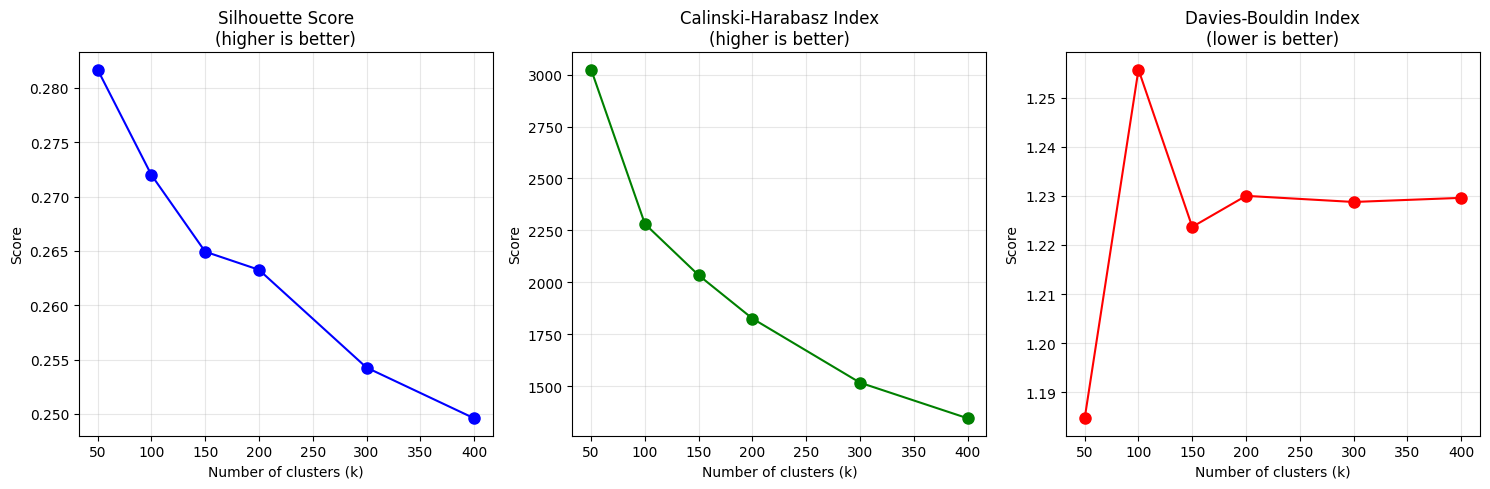

In [9]:
# Plot evaluation metrics
plt.figure(figsize=(15, 5))

# Silhouette score (higher is better)
plt.subplot(1, 3, 1)
plt.plot(
    [r["k"] for r in kmeans_results],
    [r["silhouette"] for r in kmeans_results],
    'o-',
    color='blue',
    markersize=8
)
plt.title('Silhouette Score\n(higher is better)')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Score')
plt.grid(True, alpha=0.3)

# Calinski-Harabasz index (higher is better)
plt.subplot(1, 3, 2)
plt.plot(
    [r["k"] for r in kmeans_results],
    [r["calinski_harabasz"] for r in kmeans_results],
    'o-',
    color='green',
    markersize=8
)
plt.title('Calinski-Harabasz Index\n(higher is better)')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Score')
plt.grid(True, alpha=0.3)

# Davies-Bouldin index (lower is better)
plt.subplot(1, 3, 3)
plt.plot(
    [r["k"] for r in kmeans_results],
    [r["davies_bouldin"] for r in kmeans_results],
    'o-',
    color='red',
    markersize=8
)
plt.title('Davies-Bouldin Index\n(lower is better)')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Score')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [10]:
# Select the best k based on majority voting across metrics
logger.info("Selecting best k for K-Means")

# Normalize scores for fair comparison
silhouette_scores = np.array([r["silhouette"] for r in kmeans_results])
ch_scores = np.array([r["calinski_harabasz"] for r in kmeans_results])
db_scores = np.array([r["davies_bouldin"] for r in kmeans_results])

# Normalize (min-max for silhouette and CH, max-min for DB since lower is better)
norm_sil = (silhouette_scores - np.min(silhouette_scores)) / (np.max(silhouette_scores) - np.min(silhouette_scores))
norm_ch = (ch_scores - np.min(ch_scores)) / (np.max(ch_scores) - np.min(ch_scores))
norm_db = (np.max(db_scores) - db_scores) / (np.max(db_scores) - np.min(db_scores))

# Compute ranks (1 is best)
sil_rank = np.argsort(norm_sil)[::-1] + 1
ch_rank = np.argsort(norm_ch)[::-1] + 1
db_rank = np.argsort(norm_db)[::-1] + 1

# Create a DataFrame for easier visualization
k_values = [r["k"] for r in kmeans_results]
rank_df = pd.DataFrame({
    "k": k_values,
    "silhouette": silhouette_scores,
    "silhouette_rank": sil_rank,
    "calinski_harabasz": ch_scores,
    "ch_rank": ch_rank,
    "davies_bouldin": db_scores,
    "db_rank": db_rank,
    "avg_rank": (sil_rank + ch_rank + db_rank) / 3
})

# Sort by average rank
rank_df = rank_df.sort_values("avg_rank")

logger.info("K-Means evaluation metrics and ranks:")
logger.info(rank_df.to_string())

# If we have ties or close scores, prefer smaller k
best_k_idx = rank_df.iloc[0].name
best_k = k_values[best_k_idx]

logger.info(f"Selected best k for K-Means: {best_k}")
kmeans_labels = kmeans_results[best_k_idx]["labels"]
kmeans_params = {
    "k": best_k,
    "silhouette": kmeans_results[best_k_idx]["silhouette"],
    "calinski_harabasz": kmeans_results[best_k_idx]["calinski_harabasz"],
    "davies_bouldin": kmeans_results[best_k_idx]["davies_bouldin"]
}

2025-09-02 20:49:34,654 [INFO] Selecting best k for K-Means
2025-09-02 20:49:34,664 [INFO] K-Means evaluation metrics and ranks:
2025-09-02 20:49:34,672 [INFO]      k  silhouette  silhouette_rank  calinski_harabasz  ch_rank  davies_bouldin  db_rank  avg_rank
0   50    0.281694                1        3024.130127        1        1.184666        1  1.000000
1  100    0.271994                2        2281.155762        2        1.255754        3  2.333333
2  150    0.264929                3        2034.111328        3        1.223684        5  3.666667
3  200    0.263260                4        1825.621094        4        1.230012        6  4.666667
4  300    0.254258                5        1517.184937        5        1.228764        4  4.666667
5  400    0.249588                6        1345.814331        6        1.229605        2  4.666667
2025-09-02 20:49:34,674 [INFO] Selected best k for K-Means: 50
2025-09-02 20:49:34,664 [INFO] K-Means evaluation metrics and ranks:
2025-09-02 20:4

## 7. Cluster Evaluation

If a Louvain community column exists, we'll compute ARI and NMI to compare against our DBSCAN and K-Means clustering results.

In [11]:
# Check if Louvain community column exists
louvain_comparison = None
try:
    # Try to load the file with communities
    louvain_df = pd.read_csv(f"{BASE_PATH}df_nq_version0_with_communities.csv")
    
    if "community" in louvain_df.columns:
        logger.info("Louvain community column found. Computing comparison metrics.")
        
        # Ensure IDs match between dataframes
        louvain_df = louvain_df.set_index("id")
        louvain_communities = df["id"].map(louvain_df["community"].to_dict())
        
        # Handle missing values
        louvain_communities = louvain_communities.fillna(-1).astype(int)
        
        # Compute metrics
        dbscan_ari = adjusted_rand_score(louvain_communities, dbscan_labels)
        dbscan_nmi = normalized_mutual_info_score(louvain_communities, dbscan_labels)
        kmeans_ari = adjusted_rand_score(louvain_communities, kmeans_labels)
        kmeans_nmi = normalized_mutual_info_score(louvain_communities, kmeans_labels)
        
        # Store comparison results
        louvain_comparison = {
            "dbscan_ari": dbscan_ari,
            "dbscan_nmi": dbscan_nmi,
            "kmeans_ari": kmeans_ari,
            "kmeans_nmi": kmeans_nmi
        }
        
        logger.info(f"DBSCAN vs Louvain: ARI={dbscan_ari:.4f}, NMI={dbscan_nmi:.4f}")
        logger.info(f"K-Means vs Louvain: ARI={kmeans_ari:.4f}, NMI={kmeans_nmi:.4f}")
    else:
        logger.info("No Louvain community column found in df_nq_version0_with_communities.csv")
except FileNotFoundError:
    logger.info("No Louvain community file found (df_nq_version0_with_communities.csv)")
except Exception as e:
    logger.warning(f"Error comparing with Louvain: {str(e)}")

2025-09-02 20:49:36,007 [INFO] Louvain community column found. Computing comparison metrics.
2025-09-02 20:49:36,163 [INFO] DBSCAN vs Louvain: ARI=-0.0002, NMI=0.0054
2025-09-02 20:49:36,164 [INFO] K-Means vs Louvain: ARI=0.0999, NMI=0.2737
2025-09-02 20:49:36,163 [INFO] DBSCAN vs Louvain: ARI=-0.0002, NMI=0.0054
2025-09-02 20:49:36,164 [INFO] K-Means vs Louvain: ARI=0.0999, NMI=0.2737


## 8. Cluster Labeling

Now we'll generate human-readable labels for each cluster based on the most frequent terms in the titles.

In [12]:
# Function to extract top terms from a list of titles
def extract_top_terms(titles, top_n=10):
    """Extract the most frequent meaningful terms from a list of titles."""
    # Combine all titles
    text = " ".join(titles)
    
    # Simple tokenization and cleaning
    # Remove punctuation and convert to lowercase
    text = re.sub(r'[^\w\s]', ' ', text.lower())
    
    # Split into tokens
    tokens = text.split()
    
    # Filter out stopwords and short terms
    stopwords = {
        'the', 'a', 'an', 'and', 'or', 'but', 'if', 'because', 'as', 'what',
        'which', 'this', 'that', 'these', 'those', 'then', 'just', 'so', 'than',
        'such', 'both', 'through', 'about', 'for', 'is', 'of', 'while', 'during',
        'to', 'in', 'on', 'at', 'from', 'by', 'about', 'with', 'list', 'since', 'its'
    }
    
    tokens = [t for t in tokens if t not in stopwords and len(t) > 2]
    
    # Count tokens and get top N
    counter = Counter(tokens)
    top_terms = [term for term, count in counter.most_common(top_n)]
    
    return top_terms

# Function to synthesize a cluster name from top terms
def synthesize_cluster_name(terms, max_terms=5):
    """Generate a short, descriptive name for a cluster based on top terms."""
    if not terms:
        return "Unlabeled Cluster"
    
    # Use up to max_terms, but make sure the name is not too long
    name_terms = terms[:max_terms]
    name = " & ".join(name_terms).title()
    
    # Cap the length
    if len(name) > 50:
        name = name[:47] + "..."
        
    return name

# Create DBSCAN cluster summaries
logger.info("Generating DBSCAN cluster summaries")
dbscan_clusters = {}

for label in set(dbscan_labels):
    # Skip noise cluster
    if label == -1:
        continue
        
    # Get titles in this cluster
    mask = dbscan_labels == label
    cluster_titles = df.loc[mask, "d_properties_document_title"].tolist()
    
    # Extract top terms
    top_terms = extract_top_terms(cluster_titles)
    
    # Choose representative sample titles (up to 5)
    if len(cluster_titles) <= 5:
        sample_titles = cluster_titles
    else:
        # Try to select diverse titles
        sample_titles = []
        step = max(1, len(cluster_titles) // 5)
        for i in range(0, len(cluster_titles), step):
            if len(sample_titles) < 5:
                sample_titles.append(cluster_titles[i])
    
    # Synthesize a name
    cluster_name = synthesize_cluster_name(top_terms)
    
    # Store cluster info
    dbscan_clusters[label] = {
        "cluster_id": label,
        "size": len(cluster_titles),
        "top_terms": "|".join(top_terms),
        "sample_titles": "|".join(sample_titles),
        "name": cluster_name
    }

# Create K-Means cluster summaries
logger.info("Generating K-Means cluster summaries")
kmeans_clusters = {}

for label in range(best_k):
    # Get titles in this cluster
    mask = kmeans_labels == label
    cluster_titles = df.loc[mask, "d_properties_document_title"].tolist()
    
    # Extract top terms
    top_terms = extract_top_terms(cluster_titles)
    
    # Choose representative sample titles (up to 5)
    if len(cluster_titles) <= 5:
        sample_titles = cluster_titles
    else:
        # Try to select diverse titles
        sample_titles = []
        step = max(1, len(cluster_titles) // 5)
        for i in range(0, len(cluster_titles), step):
            if len(sample_titles) < 5:
                sample_titles.append(cluster_titles[i])
    
    # Synthesize a name
    cluster_name = synthesize_cluster_name(top_terms)
    
    # Store cluster info
    kmeans_clusters[label] = {
        "cluster_id": label,
        "size": len(cluster_titles),
        "top_terms": "|".join(top_terms),
        "sample_titles": "|".join(sample_titles),
        "name": cluster_name
    }

2025-09-02 20:49:36,184 [INFO] Generating DBSCAN cluster summaries
2025-09-02 20:49:36,387 [INFO] Generating K-Means cluster summaries
2025-09-02 20:49:36,387 [INFO] Generating K-Means cluster summaries


## 9. Visualization

Let's create 2D visualizations of our clusters using either UMAP or t-SNE for better visualization.

2025-09-02 20:49:36,591 [INFO] Creating 2D embeddings for visualization
2025-09-02 20:49:36,592 [INFO] Dataset too large for visualization, sampling 50000 points
2025-09-02 20:49:36,592 [INFO] Dataset too large for visualization, sampling 50000 points
2025-09-02 20:49:36,604 [INFO] Creating DBSCAN visualization
2025-09-02 20:49:36,604 [INFO] Creating DBSCAN visualization


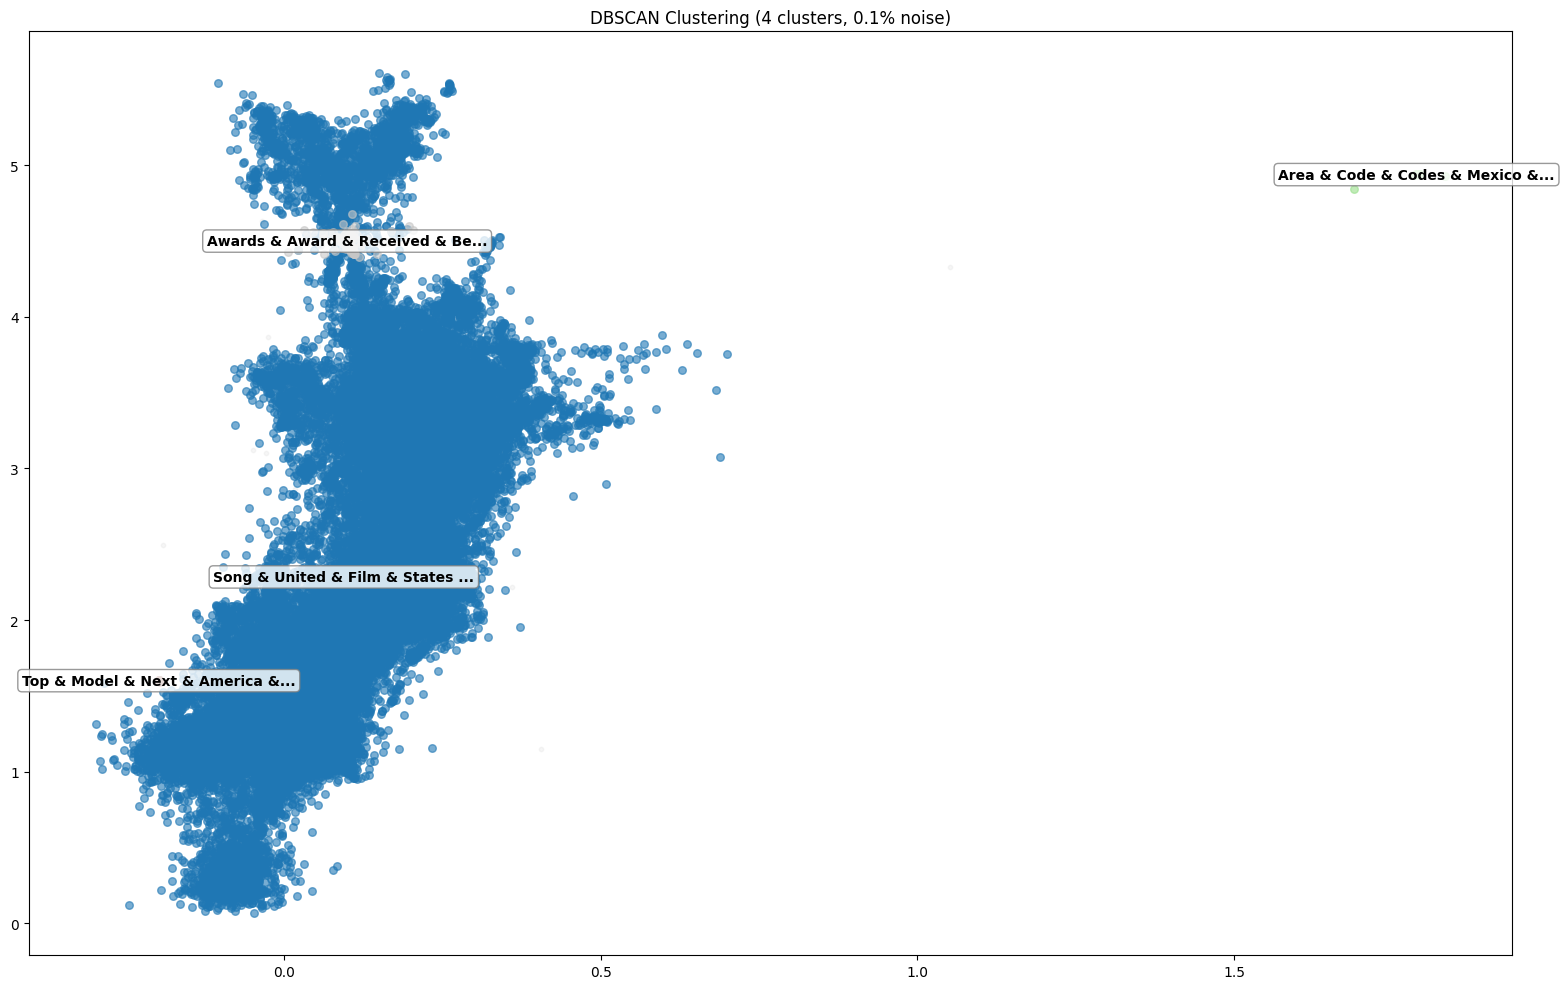

2025-09-02 20:49:38,270 [INFO] Creating K-Means visualization


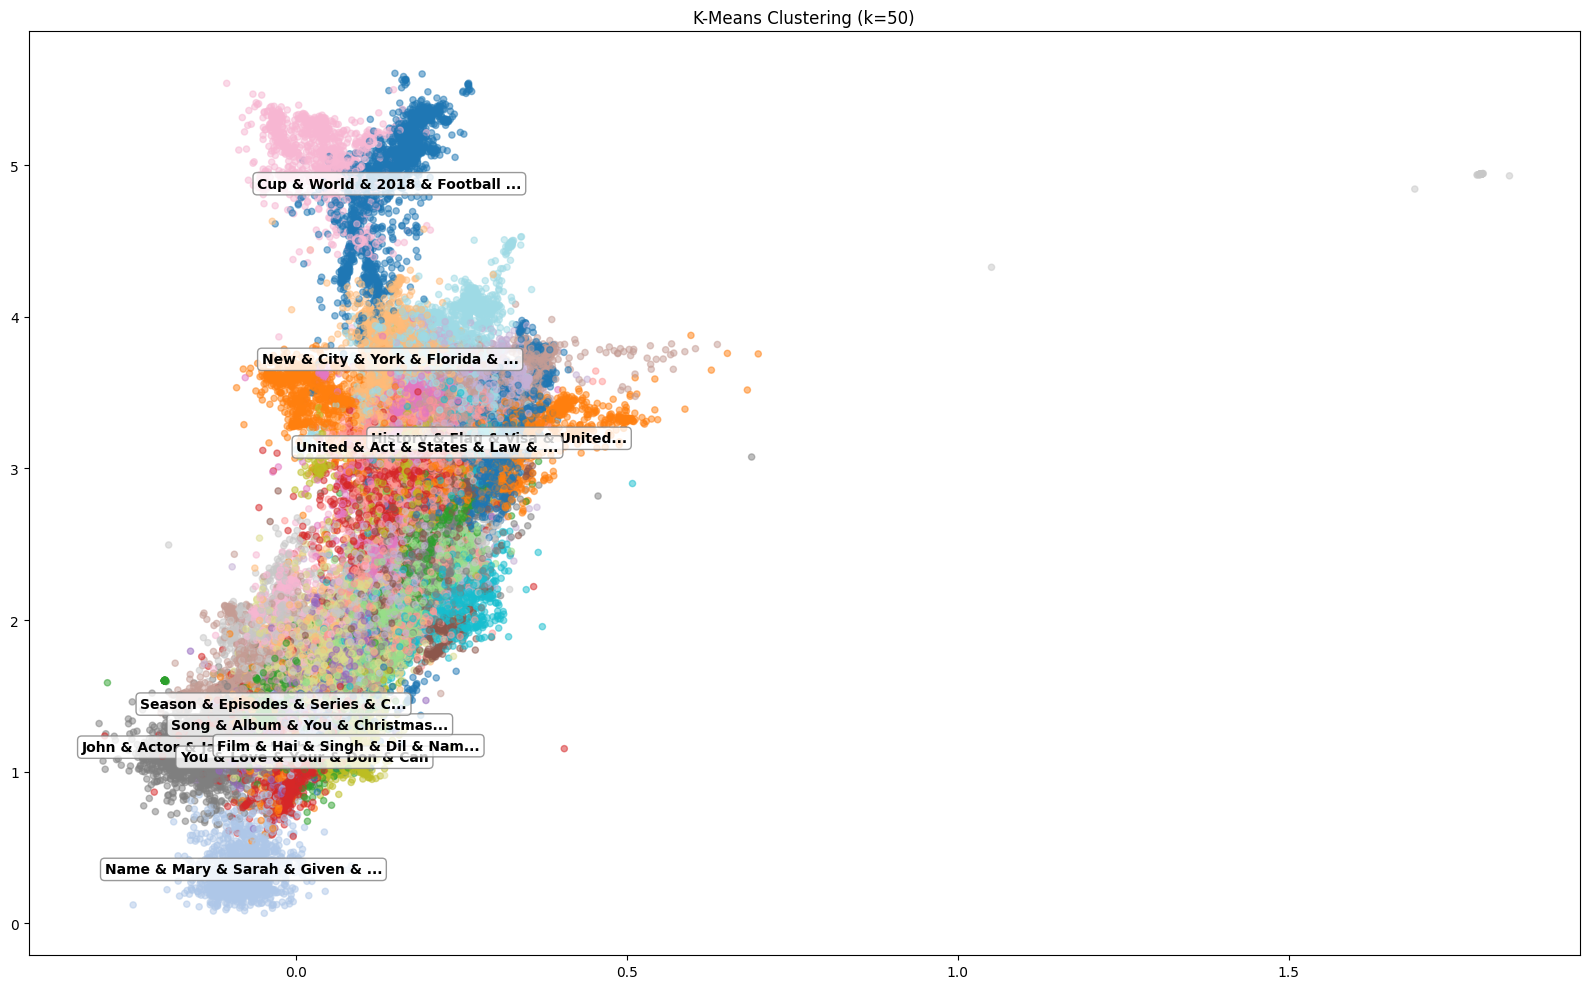

In [13]:
# Create 2D embeddings for visualization
logger.info("Creating 2D embeddings for visualization")

# Sample if dataset is large
max_viz_points = 50000
if len(df) > max_viz_points:
    logger.info(f"Dataset too large for visualization, sampling {max_viz_points} points")
    viz_indices = np.random.choice(len(df), max_viz_points, replace=False)
else:
    viz_indices = np.arange(len(df))

# Get the visualization features
if projection_method == "umap" or projection_method == "pca":
    # We already have reduced embeddings, just take a sample
    viz_features = reduced_embeddings[viz_indices]
else:
    # We need to reduce the raw embeddings first
    if sparse.issparse(embeddings):
        viz_features_raw = embeddings[viz_indices].toarray()
    else:
        viz_features_raw = embeddings[viz_indices]
    
    # Use t-SNE for visualization if UMAP is not available
    try:
        import umap
        reducer = umap.UMAP(
            n_components=2,
            n_neighbors=30,
            min_dist=0.1,
            metric='cosine',
            random_state=RANDOM_STATE
        )
        viz_features = reducer.fit_transform(viz_features_raw)
        viz_method = "umap"
    except ImportError:
        logger.warning("UMAP not available for visualization, using t-SNE")
        tsne = TSNE(
            n_components=2,
            perplexity=30,
            n_iter=1000,
            metric='cosine',
            random_state=RANDOM_STATE
        )
        viz_features = tsne.fit_transform(viz_features_raw)
        viz_method = "tsne"

# Get cluster labels for visualization
viz_dbscan_labels = dbscan_labels[viz_indices]
viz_kmeans_labels = kmeans_labels[viz_indices]

# Create DBSCAN visualization
logger.info("Creating DBSCAN visualization")
plt.figure(figsize=(16, 10))

# Plot each cluster with a different color
unique_labels = set(viz_dbscan_labels)
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_labels)))

# Plot noise points first so they're in the background
if -1 in unique_labels:
    noise_mask = viz_dbscan_labels == -1
    plt.scatter(
        viz_features[noise_mask, 0],
        viz_features[noise_mask, 1],
        s=10,
        c='lightgrey',
        alpha=0.2,
        label='Noise'
    )

# Plot clusters
for i, label in enumerate(sorted([l for l in unique_labels if l != -1])):
    mask = viz_dbscan_labels == label
    plt.scatter(
        viz_features[mask, 0],
        viz_features[mask, 1],
        s=30,
        c=[colors[i % len(colors)]],
        alpha=0.6,
        label=f'Cluster {label}'
    )

# Annotate the largest clusters
largest_dbscan_clusters = sorted(
    [(label, np.sum(viz_dbscan_labels == label)) for label in unique_labels if label != -1],
    key=lambda x: x[1],
    reverse=True
)[:10]

for label, count in largest_dbscan_clusters:
    # Find the center of the cluster
    mask = viz_dbscan_labels == label
    if np.sum(mask) > 0:
        center_x = np.mean(viz_features[mask, 0])
        center_y = np.mean(viz_features[mask, 1])
        
        # Get the cluster name if available
        if label in dbscan_clusters:
            name = dbscan_clusters[label]["name"]
            short_name = name[:30] + "..." if len(name) > 30 else name
        else:
            short_name = f"Cluster {label}"
        
        plt.annotate(
            short_name,
            (center_x, center_y),
            fontsize=10,
            fontweight='bold',
            ha='center',
            va='center',
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
        )

plt.title(f'DBSCAN Clustering ({dbscan_params["n_clusters"]} clusters, {dbscan_params["noise_percent"]:.1f}% noise)')
plt.grid(False)
plt.tight_layout()

# Save the DBSCAN visualization
if projection_method == "umap":
    plt.savefig(f"{BASE_PATH}umap_dbscan.png", dpi=300, bbox_inches='tight')
else:
    plt.savefig(f"{BASE_PATH}pca_dbscan.png", dpi=300, bbox_inches='tight')

plt.show()

# Create K-Means visualization
logger.info("Creating K-Means visualization")
plt.figure(figsize=(16, 10))

# Plot each cluster with a different color
# We'll use a continuous colormap since there are many clusters
scatter = plt.scatter(
    viz_features[:, 0],
    viz_features[:, 1],
    s=20,
    c=viz_kmeans_labels,
    cmap='tab20',
    alpha=0.5
)

# Annotate the largest clusters
largest_kmeans_clusters = sorted(
    [(label, np.sum(viz_kmeans_labels == label)) for label in range(best_k)],
    key=lambda x: x[1],
    reverse=True
)[:10]

for label, count in largest_kmeans_clusters:
    # Find the center of the cluster
    mask = viz_kmeans_labels == label
    if np.sum(mask) > 0:
        center_x = np.mean(viz_features[mask, 0])
        center_y = np.mean(viz_features[mask, 1])
        
        # Get the cluster name if available
        if label in kmeans_clusters:
            name = kmeans_clusters[label]["name"]
            short_name = name[:30] + "..." if len(name) > 30 else name
        else:
            short_name = f"Cluster {label}"
        
        plt.annotate(
            short_name,
            (center_x, center_y),
            fontsize=10,
            fontweight='bold',
            ha='center',
            va='center',
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
        )

plt.title(f'K-Means Clustering (k={best_k})')
plt.grid(False)
plt.tight_layout()

# Save the K-Means visualization
if projection_method == "umap":
    plt.savefig(f"{BASE_PATH}umap_kmeans.png", dpi=300, bbox_inches='tight')
else:
    plt.savefig(f"{BASE_PATH}pca_kmeans.png", dpi=300, bbox_inches='tight')

plt.show()

## 10. Results Export

Finally, we'll export all required outputs.

In [14]:
# 1. Create master table
logger.info("Creating master table")

df_master = pd.DataFrame({
    "id": df["id"],
    "title": df["d_properties_document_title"],
    "slug": df["d_properties_title_encode"],
    "dbscan_label": dbscan_labels,
    "dbscan_core": dbscan_core_samples_mask,
    "noise": dbscan_labels == -1,
    "kmeans_label": kmeans_labels,
    "kbest": best_k,
    "embedding_model": embedding_model_name,
    "projection_used": projection_name
})

# Save as parquet
logger.info(f"Saving master table to {MASTER_FILE}")
df_master.to_parquet(MASTER_FILE, index=False, engine="pyarrow")

# 2. Create DBSCAN summary CSV
logger.info(f"Saving DBSCAN summary to {DBSCAN_SUMMARY_FILE}")
dbscan_summary_df = pd.DataFrame(list(dbscan_clusters.values()))
if len(dbscan_summary_df) > 0:  # Check if there are any non-noise clusters
    dbscan_summary_df = dbscan_summary_df.sort_values("size", ascending=False)
    dbscan_summary_df.to_csv(DBSCAN_SUMMARY_FILE, index=False)
else:
    logger.warning("No DBSCAN clusters to summarize (all points are noise)")
    # Create an empty summary file with the required columns
    pd.DataFrame(columns=["cluster_id", "size", "top_terms", "sample_titles", "name"]).to_csv(DBSCAN_SUMMARY_FILE, index=False)

# 3. Create K-Means summary CSV
logger.info(f"Saving K-Means summary to {KMEANS_SUMMARY_FILE}")
kmeans_summary_df = pd.DataFrame(list(kmeans_clusters.values()))
kmeans_summary_df = kmeans_summary_df.sort_values("size", ascending=False)
kmeans_summary_df.to_csv(KMEANS_SUMMARY_FILE, index=False)

# 4. Create evaluation JSON
logger.info(f"Saving evaluation metrics to {EVAL_FILE}")
eval_data = {
    "embedding": {
        "method": embedding_method,
        "model": embedding_model_name,
        "dimensions": embeddings.shape[1] if hasattr(embeddings, "shape") and not sparse.issparse(embeddings)
                    else embeddings.shape[1] if sparse.issparse(embeddings)
                    else None
    },
    "projection": {
        "method": projection_method,
        "name": projection_name,
        "dimensions": reduced_embeddings.shape[1] if reduced_embeddings is not None else None
    },
    "dbscan": {
        "grid": [
            {
                "min_samples": r["min_samples"],
                "eps": r["eps"],
                "n_clusters": r["n_clusters"],
                "n_noise": r["n_noise"],
                "noise_percent": r["noise_percent"],
                "silhouette": r["silhouette"]
            } for r in dbscan_results
        ],
        "chosen_params": dbscan_params
    },
    "kmeans": {
        "grid": [
            {
                "k": r["k"],
                "silhouette": r["silhouette"],
                "calinski_harabasz": r["calinski_harabasz"],
                "davies_bouldin": r["davies_bouldin"]
            } for r in kmeans_results
        ],
        "chosen_k": best_k,
        "metrics_table": rank_df.to_dict(orient="records")
    }
}

# Add Louvain comparison if available
if louvain_comparison:
    eval_data["louvain_comparison"] = louvain_comparison

# Save as JSON
with open(EVAL_FILE, "w") as f:
    json.dump(eval_data, f, indent=2)

# Save a simple log summary
logger.info("Saving summary log")
end_time = time.time()
runtime = end_time - start_time

log_summary = [
    "=== Wikipedia Title Clustering Summary ===",
    f"Run completed on: {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}",
    f"Total runtime: {runtime:.1f} seconds",
    "",
    f"Dataset size: {len(df)} articles",
    "",
    f"Embedding method: {embedding_method}",
    f"Embedding model: {embedding_model_name}",
    f"Projection method: {projection_method} ({projection_name})",
    "",
    f"DBSCAN results:",
    f"- Parameters: min_samples={dbscan_params['min_samples']}, eps={dbscan_params['eps']:.4f}",
    f"- Clusters: {dbscan_params['n_clusters']}",
    f"- Noise points: {dbscan_params['n_noise']} ({dbscan_params['noise_percent']:.1f}%)",
    f"- Silhouette score: {dbscan_params['silhouette']:.4f}",
    "",
    f"K-Means results:",
    f"- K: {best_k}",
    f"- Silhouette score: {kmeans_params['silhouette']:.4f}",
    f"- Calinski-Harabasz index: {kmeans_params['calinski_harabasz']:.1f}",
    f"- Davies-Bouldin index: {kmeans_params['davies_bouldin']:.4f}",
    "",
    "Output files:",
    f"- Master table: {MASTER_FILE}",
    f"- DBSCAN summary: {DBSCAN_SUMMARY_FILE}",
    f"- K-Means summary: {KMEANS_SUMMARY_FILE}",
    f"- Evaluation metrics: {EVAL_FILE}",
    f"- Visualizations: {BASE_PATH}{'umap' if projection_method == 'umap' else 'pca'}_dbscan.png, " +
    f"{BASE_PATH}{'umap' if projection_method == 'umap' else 'pca'}_kmeans.png"
]

# Print summary
print("\n".join(log_summary))

# Also append to log file
with open(f"{BASE_PATH}log.txt", "a") as f:
    f.write("\n\n" + "\n".join(log_summary))

logger.info("All tasks completed successfully!")

2025-09-02 20:49:42,396 [INFO] Creating master table
2025-09-02 20:49:42,497 [INFO] Saving master table to ../data/v0.0/wiki_clusters.parquet
2025-09-02 20:49:42,497 [INFO] Saving master table to ../data/v0.0/wiki_clusters.parquet
2025-09-02 20:49:42,983 [INFO] Saving DBSCAN summary to ../data/v0.0/wiki_dbscan_summary.csv
2025-09-02 20:49:43,000 [INFO] Saving K-Means summary to ../data/v0.0/wiki_kmeans_summary.csv
2025-09-02 20:49:42,983 [INFO] Saving DBSCAN summary to ../data/v0.0/wiki_dbscan_summary.csv
2025-09-02 20:49:43,000 [INFO] Saving K-Means summary to ../data/v0.0/wiki_kmeans_summary.csv
2025-09-02 20:49:43,006 [INFO] Saving evaluation metrics to ../data/v0.0/cluster_eval.json
2025-09-02 20:49:43,006 [INFO] Saving evaluation metrics to ../data/v0.0/cluster_eval.json
2025-09-02 20:49:43,015 [INFO] Saving summary log
2025-09-02 20:49:43,018 [INFO] All tasks completed successfully!
2025-09-02 20:49:43,015 [INFO] Saving summary log
2025-09-02 20:49:43,018 [INFO] All tasks complet

=== Wikipedia Title Clustering Summary ===
Run completed on: 2025-09-02 20:49:43
Total runtime: 796.3 seconds

Dataset size: 108071 articles

Embedding method: transformer
Embedding model: all-MiniLM-L6-v2
Projection method: umap (UMAP-15)

DBSCAN results:
- Parameters: min_samples=5, eps=0.6170
- Clusters: 4
- Noise points: 84 (0.1%)
- Silhouette score: 0.2479

K-Means results:
- K: 50
- Silhouette score: 0.2817
- Calinski-Harabasz index: 3024.1
- Davies-Bouldin index: 1.1847

Output files:
- Master table: ../data/v0.0/wiki_clusters.parquet
- DBSCAN summary: ../data/v0.0/wiki_dbscan_summary.csv
- K-Means summary: ../data/v0.0/wiki_kmeans_summary.csv
- Evaluation metrics: ../data/v0.0/cluster_eval.json
- Visualizations: ../data/v0.0/umap_dbscan.png, ../data/v0.0/umap_kmeans.png
